In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [67]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/CAPSTONE/learning_styles.csv')
df.head()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15,Learner
0,3,3,4,3,2,4,3,3,2,3,4,2,2,3,3,K
1,5,4,4,4,3,3,2,4,3,4,3,4,3,4,4,A
2,3,4,3,3,4,2,4,3,2,2,3,2,3,3,3,A
3,1,3,3,4,4,2,2,2,2,2,4,4,4,4,5,K
4,4,4,4,5,5,4,4,3,4,4,5,5,5,3,3,A


In [68]:
classes = df['Learner'].unique()
num_classes = len(classes)
dummy_class = []
mapper = {}
for i, cl in enumerate(classes):
    mapper[cl] = i
    dummy_class.append(f"Learner_{i}")

In [69]:
df = df.replace(mapper)
df.head()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15,Learner
0,3,3,4,3,2,4,3,3,2,3,4,2,2,3,3,0
1,5,4,4,4,3,3,2,4,3,4,3,4,3,4,4,1
2,3,4,3,3,4,2,4,3,2,2,3,2,3,3,3,1
3,1,3,3,4,4,2,2,2,2,2,4,4,4,4,5,0
4,4,4,4,5,5,4,4,3,4,4,5,5,5,3,3,1


In [70]:
df = pd.get_dummies(df, columns=['Learner'])
df.head()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15,Learner_0,Learner_1,Learner_2
0,3,3,4,3,2,4,3,3,2,3,4,2,2,3,3,1,0,0
1,5,4,4,4,3,3,2,4,3,4,3,4,3,4,4,0,1,0
2,3,4,3,3,4,2,4,3,2,2,3,2,3,3,3,0,1,0
3,1,3,3,4,4,2,2,2,2,2,4,4,4,4,5,1,0,0
4,4,4,4,5,5,4,4,3,4,4,5,5,5,3,3,0,1,0


In [71]:
#Spit the dataset for training (85%)
train_df = df.sample(frac=0.85, random_state=1)
valid_df = df.drop(train_df.index)

In [72]:
train_labels_df = pd.concat([train_df.pop(dc) for dc in dummy_class], axis=1)
valid_labels_df = pd.concat([valid_df.pop(dc) for dc in dummy_class], axis=1)
train_labels_df.head()

,Learner_0,Learner_1,Learner_2
584,0,1,0
970,1,0,0
701,1,0,0
619,0,0,1
534,1,0,0


In [75]:
# Scaling dataset
stats = train_df.describe().transpose()
train_df = (train_df-stats['mean'])/stats['std']
valid_df = (valid_df-stats['mean'])/stats['std']
train_df.head()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15
584,0.631752,0.549139,0.628027,-0.278402,0.698535,0.503886,-0.410783,-0.299996,0.688405,0.599818,0.420944,-0.542515,-0.551207,0.568243,0.497095
970,0.631752,0.549139,-1.358471,-0.278402,-0.193507,0.503886,1.535229,1.541175,1.624491,-1.294537,1.291628,1.348013,1.208546,1.527446,0.497095
701,-1.149980,0.549139,1.621276,0.675588,1.590576,1.498117,0.562223,-1.220582,0.688405,0.599818,1.291628,1.348013,1.208546,-0.390959,0.497095
619,-0.259114,0.549139,-1.358471,0.675588,-0.193507,0.503886,-0.410783,0.620589,-0.247680,0.599818,-1.320425,-0.542515,-0.551207,0.568243,0.497095
534,0.631752,0.549139,-0.365222,0.675588,0.698535,1.498117,-0.410783,0.620589,0.688405,-1.294537,0.420944,0.402749,-0.551207,0.568243,0.497095


In [76]:
# Converting to numpy
train_data = train_df.to_numpy()
valid_data = valid_df.to_numpy()


train_labels = train_labels_df.to_numpy()
valid_labels = valid_labels_df.to_numpy()


In [77]:
# Storing data for future prediction
prediction_data = train_df.iloc[0]
result = train_labels_df.iloc[0]

In [78]:
# Prepare dataset
def prepare_dataset(data, labels, batch, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices((data, labels))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.batch(batch).prefetch(1)
    return dataset

In [79]:
# training and valida dataset
batch_size = 32
buffer = 50
train_dataset = prepare_dataset(train_data, train_labels, batch_size, buffer)
valid_dataset = prepare_dataset(valid_data, valid_labels, batch_size, buffer)

In [80]:
# Build Model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])


model.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer=tf.keras.optimizers.SGD(),
    metrics=['accuracy', 'mae']
)

history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=valid_dataset
)

Epoch 1/100
33/33 [==============================] - 1s 7ms/step - loss: 1.0412 - accuracy: 0.4669 - mae: 0.4269 - val_loss: 0.9712 - val_accuracy: 0.5385 - val_mae: 0.4067
Epoch 2/100
33/33 [==============================] - 0s 3ms/step - loss: 0.9241 - accuracy: 0.5827 - mae: 0.3891 - val_loss: 0.8979 - val_accuracy: 0.5604 - val_mae: 0.3811
Epoch 3/100
33/33 [==============================] - 0s 2ms/step - loss: 0.8534 - accuracy: 0.6021 - mae: 0.3644 - val_loss: 0.8385 - val_accuracy: 0.5879 - val_mae: 0.3606
Epoch 4/100
33/33 [==============================] - 0s 3ms/step - loss: 0.7953 - accuracy: 0.6381 - mae: 0.3443 - val_loss: 0.7830 - val_accuracy: 0.6374 - val_mae: 0.3432
Epoch 5/100
33/33 [==============================] - 0s 3ms/step - loss: 0.7418 - accuracy: 0.6790 - mae: 0.3266 - val_loss: 0.7349 - val_accuracy: 0.6758 - val_mae: 0.3253
Epoch 6/100
33/33 [==============================] - 0s 2ms/step - loss: 0.6939 - accuracy: 0.7072 - mae: 0.3088 - val_loss: 0.6858 - v

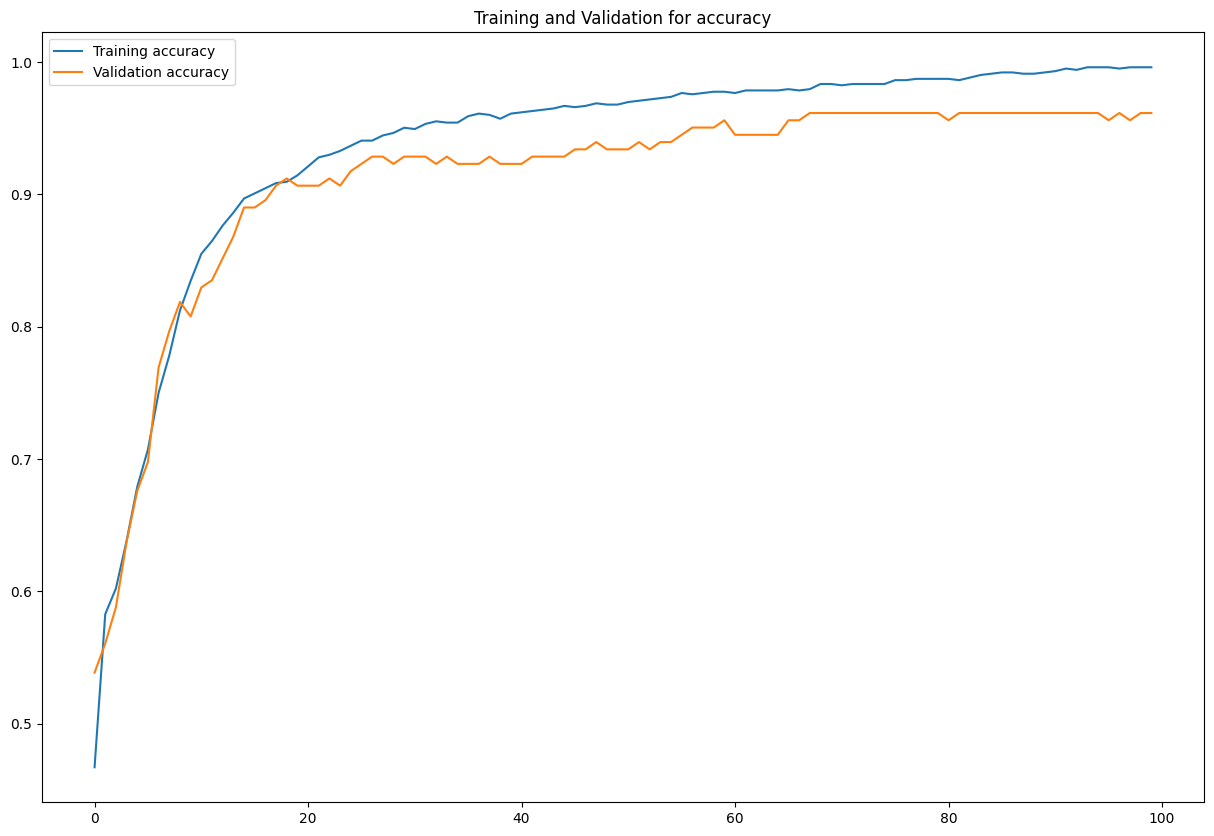

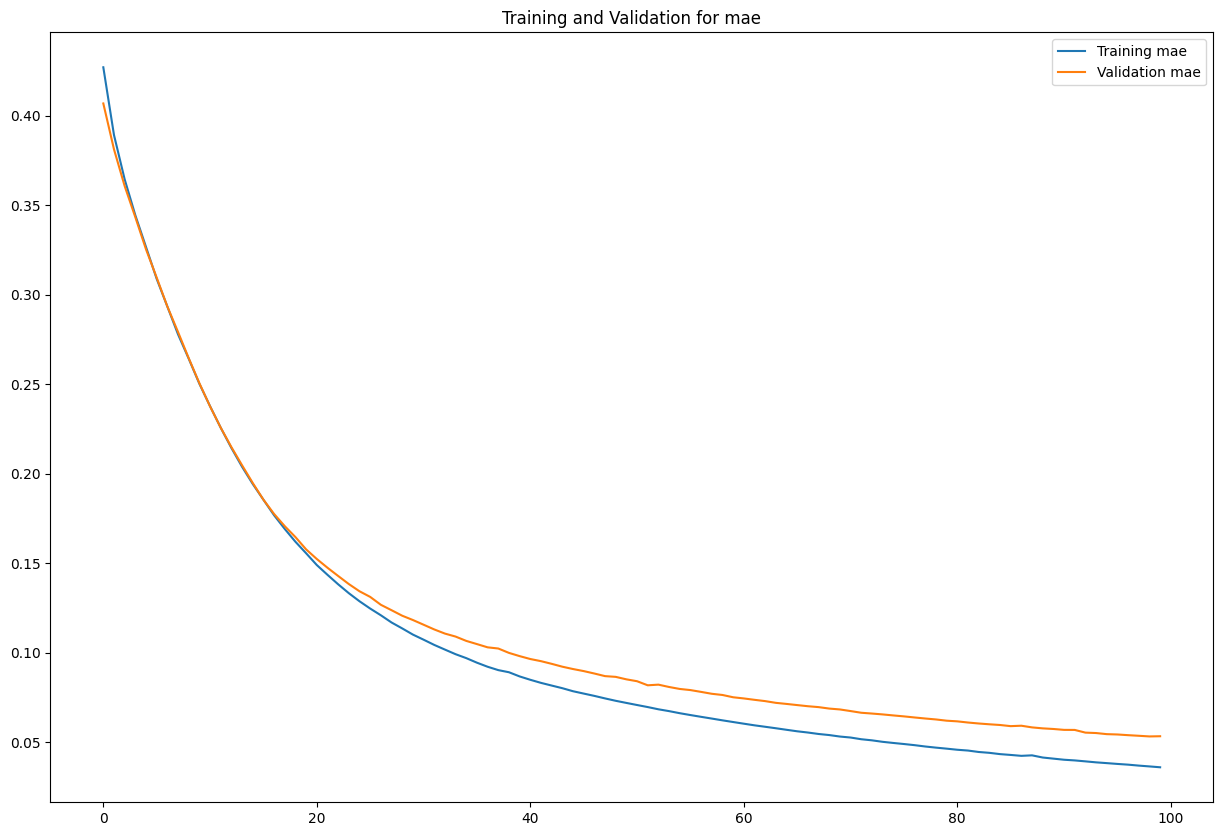

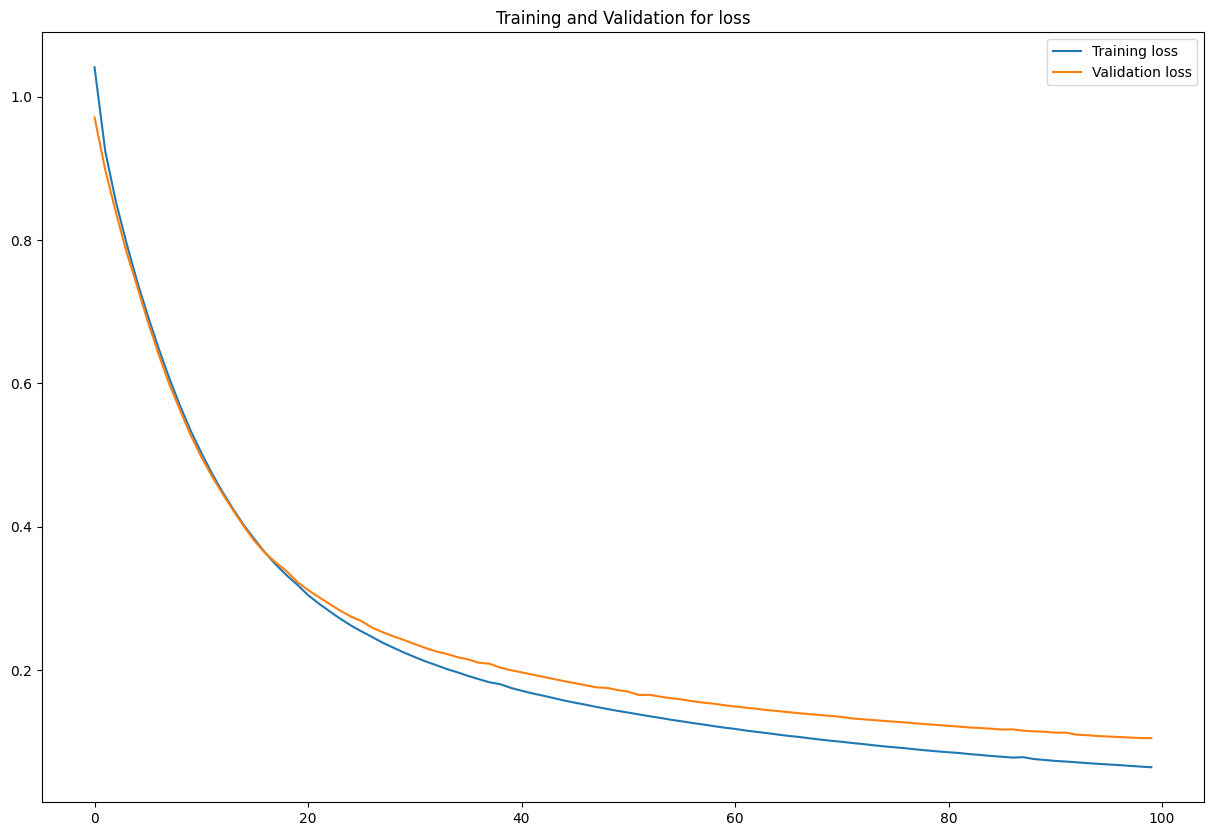

In [81]:
# plotting Graphs
plots = ['accuracy', 'mae', 'loss']
for plot in plots:
    metric = history.history[plot]
    val_metric = history.history[f"val_{plot}"]
    epochs = range(len(metric))

    plt.figure(figsize=(15, 10))
    plt.plot(epochs, metric, label=f"Training {plot}")
    plt.plot(epochs, val_metric, label=f"Validation {plot}")
    plt.legend()
    plt.title(f"Training and Validation for {plot}")
    plt.show()